In [66]:
TEST_IMG_OUTPUT_PATH = "test_images_output"

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [68]:
DEBUG_SAVING_MODE = True
class ImagePrinter():
    def __init__(self, path):
        self.path = path
        self.reset()
        
    def write(self, img, name):
        if (not DEBUG_SAVING_MODE) or self.is_blocked:
            return
        filename = "{:04d}_{}.jpg".format(self.number, name)
        self.number += 1
        cv2.imwrite(os.path.join(self.path, filename), img)

    def reset(self):
        self.number = 0
        self.is_blocked = False
        
    def block(self):
        self.is_blocked = True
        
    def unblock(self):
        self.is_blocked = False
        

In [69]:
imgprinter = ImagePrinter(TEST_IMG_OUTPUT_PATH)

In [70]:
FIGURE_SIZE = (12, 6)

In [71]:
import os

if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge02.jpg', 'test_images/challenge3.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [72]:
from camera_calibrator import CameraCalibrator, Undistorter



In [73]:
calibrator = CameraCalibrator(9, 6)

calibrator.calibrate()

Resetting Calibrator ...
Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration20.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration11.jpg ...
Calibration successful


In [74]:
mtx, dist = calibrator.get_calibration_data()
print(mtx, dist, calibrator.get_shape())
undistorter = Undistorter(mtx, dist, calibrator.get_shape())

[[1.15777942e+03 0.00000000e+00 6.67111050e+02]
 [0.00000000e+00 1.15282305e+03 3.86129068e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688833 -0.02372816 -0.00109843  0.00035105 -0.00259134]] (720, 1280)


In [75]:
imgprinter.reset()

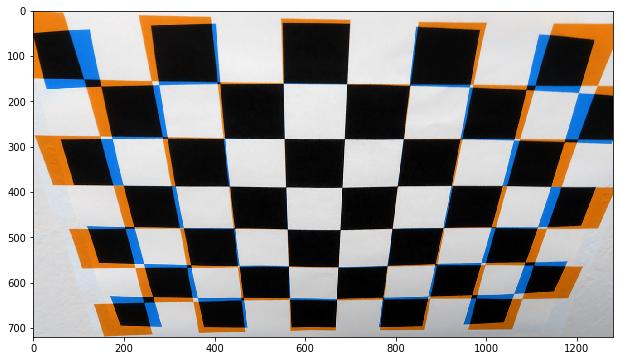

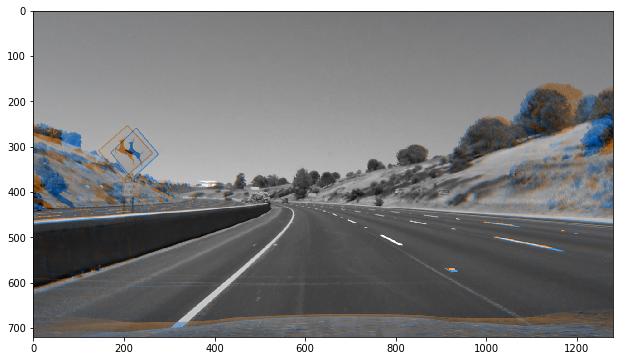

In [76]:
#
#    Calibrator and Undistorter validation
#

for filename in ['camera_cal/calibration2.jpg', test_images[6]]:
    img = cv2.imread(filename)
    distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistorted = undistorter.undistort(distorted)

    out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
    output = np.zeros(out_shape, dtype=np.uint8)
    output[:,:,0] = distorted
    output[:,:,1] = distorted//2 + undistorted//2
    output[:,:,2] = undistorted

    imgprinter.write(distorted, "distorted")
    imgprinter.write(undistorted, "undistorted")
    imgprinter.write(output, "undistorted_plus_distorted")

    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(output)



In [77]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a grayscale image """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized

In [78]:
h_center = 1280//2
w_offset = 70
top = 440#460#450
bottom = 660
left = 150
right = 1130
MASK_ROI = np.array([[left, bottom],
                [h_center - w_offset, top],
                [h_center + w_offset, top],
                [right, bottom]]
               , np.int32)
mask = cv2.fillPoly(np.zeros((720,1280), dtype=np.uint8), [MASK_ROI], [255,255,255])

In [104]:

# Regular video best ROI is [210..1070] width, top 450 hoffs 40
# this corresponds (from above) to 700 pix x width == 3.75m, 720 pix y height = 27 m
h_center = 640
h_offset = 70    # 50 for regular, 70 for challenge
top = 475        # 450 for regular vid, 475 for challenge
bottom = 690
left = 210
right = 1070
CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

class Bird():
    def __init__(self, roi, camera_roi=CAMERA_ROI):
        # ROIs are expected to be np.float32 arrays of shape (4, 2)
        # describing a region starting from the bottom left point clockwise
        self.roi = roi
        self.camera_roi = camera_roi
        self.M = cv2.getPerspectiveTransform(camera_roi, roi)
        self.invM = cv2.getPerspectiveTransform(roi, camera_roi)
    
    def from_above(self, img):
        return cv2.warpPerspective(img, self.M, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)
    
    def to_road(self, img):
        return cv2.warpPerspective(img, self.invM, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)

def to_birdseye(img, roi=CAMERA_ROI):
    """ Expects a trapezoidal ROI to start from the bottom left point """
    """ Expects an undistorted input image """

    M = cv2.getPerspectiveTransform(roi.astype(np.float32), birds_roi)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

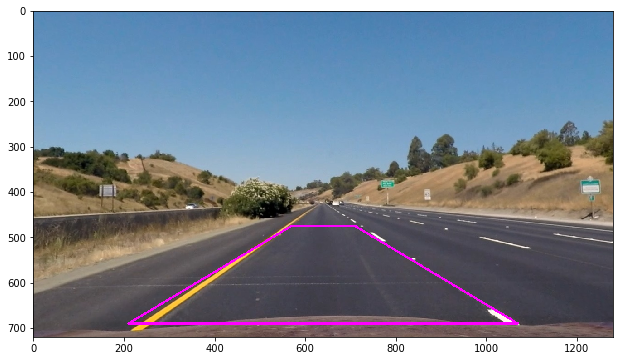

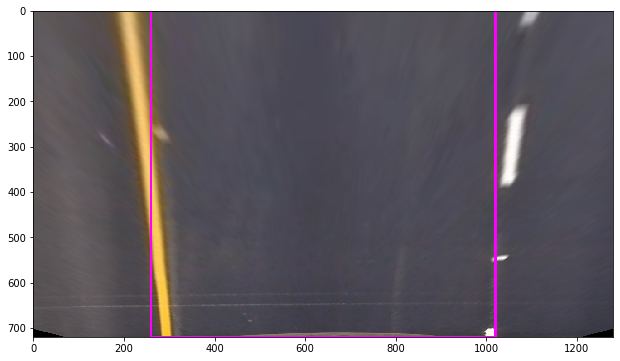

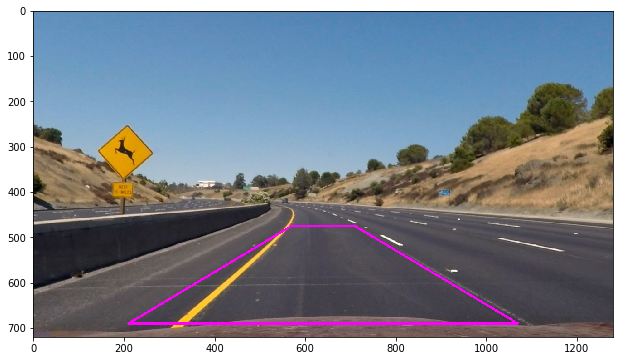

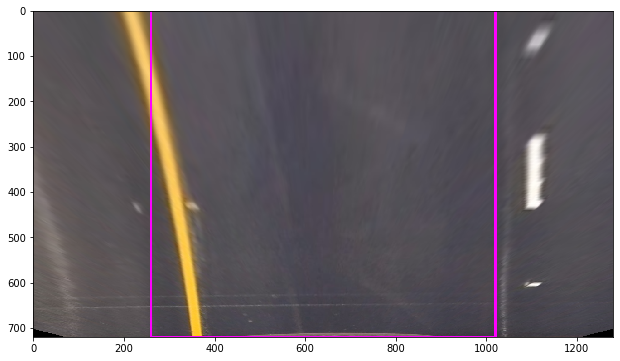

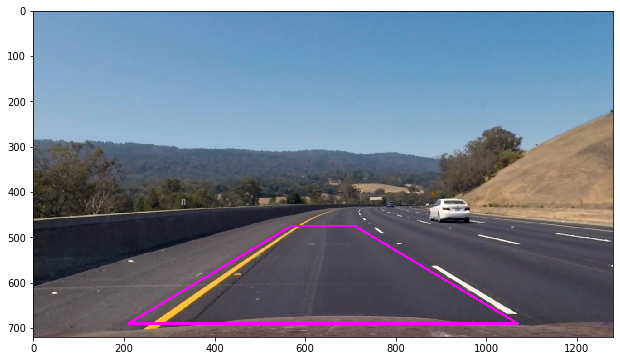

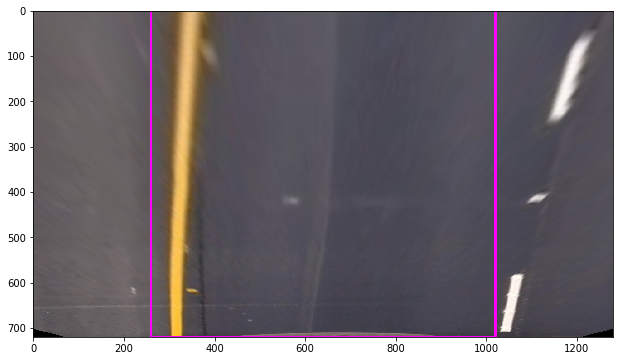

In [105]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in [3,6,7]: # 3,6 and 7 are good examples

    img = cv2.resize(cv2.imread(test_images[test_img]), (1280, 720))
    
    fpv = undistorter.undistort(img)
    
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
    imgprinter.write(fpv_roi, "transform_roi")
        
    plot_bgr(fpv_roi)
    
    birds_eye = plot_roi_on(bird.from_above(fpv), BIRD_ROI.astype(np.int32))
    imgprinter.write(birds_eye, "birds_eye")

    plot_bgr(birds_eye)

In [100]:
def subtract_major_tone(img, downsample_rate=2, accuracy=10):
    """ 
    Finds the nmost popular pixel brightness (major tone) 
    and then subtracts it from the whole image. This way we shift
    brightness curve without adding significant artifacts (as opposed
    to a regular thresholding)
    """
    hist = np.histogram(img[::downsample_rate, ::downsample_rate], accuracy)
    major = hist[1][np.argmax(hist[0])]
    if (major <= 1.0):
        # In some cases, the most popular pixel in an image is black
        # and so there's nothing to subtract; but still we believe
        # the lane markings to be the brightest, and just
        # subtract the _second_ most popular pixel brightness.
        second_max = np.partition(hist[0], -2)[-2]
        second_max_idx = np.where(hist[0] == second_max)[0][0]
        major = hist[1][second_max_idx]

    return np.maximum(0, img.astype(np.int32) - major)

def adaptive_vertical_contrast(img, downsample_rate=2, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    imgprinter.write(hls, "hls_color_space")
    
    # Downsampling significantly increases processing speed
    # while introducing only a minor artifacts
    G = img[::downsample_rate, ::downsample_rate, 1]
    R = img[::downsample_rate, ::downsample_rate, 2]
    
    quarter_lum = hls[::downsample_rate, ::downsample_rate, 1]
    quarter_sat = hls[::downsample_rate, ::downsample_rate, 2]
    imgprinter.write(quarter_lum, "luminosity")
    imgprinter.write(quarter_sat, "saturation")

    
    # Yellow lane marking is the best recognizeabe as a sum of
    # yellow brightness and saturation channel
    yellow = R//2 + G//2
    imgprinter.write(yellow, "yellow")
    filtered_yellow = subtract_major_tone(yellow)
    imgprinter.write(filtered_yellow, "yellow_balanced")

    quarter_sat = quarter_sat//2 + filtered_yellow//2
    imgprinter.write(quarter_sat, "sat_plus_yellow")
    
    min_lum = subtract_major_tone(subtract_major_tone(quarter_lum))
    imgprinter.write(min_lum, "luminosity_balanced")
    lum_part = normalize(np.minimum(np.power(min_lum, 2), 2500)) #2500
    imgprinter.write(lum_part, "luminosity_highcontrast")


    min_sat = subtract_major_tone(subtract_major_tone(quarter_sat))
    imgprinter.write(min_sat, "yellsat_balanced")
    sat_part = normalize(np.minimum(np.power(min_sat, 2), 2000))
    imgprinter.write(sat_part, "yellsat_highcontrast")


    mix = np.uint16(np.maximum(sat_part, lum_part))
    imgprinter.write(mix, "yellsat_mix_lum")
    mix = normalize(np.power(mix, 2))
    imgprinter.write(mix, "yellsat_mix_lum_highcontrast")
    
    clamped_mix = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    imgprinter.write(clamped_mix, "yellsat_mix_lum_highcontrast_clamped")
    output = cv2.resize(clamped_mix, (width, height))
    return output

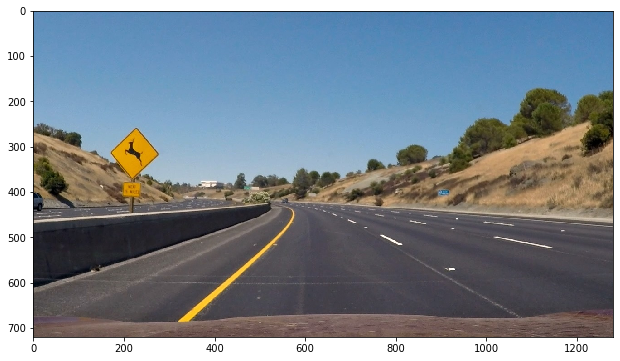

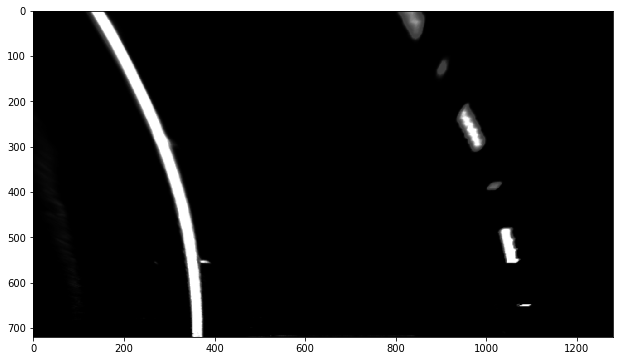

In [82]:
# Validate the HLS pipeline
for test_img in test_images[6:7]:
    imgprinter.block()
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    temp = adaptive_vertical_contrast(
        bird.from_above(
            undistorter.undistort(img)
        )
    )
    imgprinter.unblock()
    plot_bgr(img)
    plot_gray(temp)

In [83]:
def amplify_vert_lane_pixels(gray_input, blur_radius=5, sobel_kernel=7,
                             angle_range=(-0.5, 0.5), magnitude_range=(20,255),
                             downsample_rate=4, save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    downsample = gray_input[::downsample_rate, ::downsample_rate]

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobelx), "abs_sobelx_kernel_{}".format(sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(downsample, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    imgprinter.write(normalize(abs_sobely), "abs_sobely_kernel_{}".format(sobel_kernel))

    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    imgprinter.write(normalize(angles), "gradient_angles")
    (angle_min, angle_max) = angle_range

    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    imgprinter.write(normalize(mag_raw), "gradient_magnitude")
    min_magnitude, max_magnitude = magnitude_range;

    # Combining thresholds
    combined = np.zeros_like(downsample)
    combined[(((mag_raw > min_magnitude) & (mag_raw <= max_magnitude))\
              & ((angles >= angle_min) & (angles <= angle_max)))] = 255
    imgprinter.write(normalize(combined), "angle_magnitude_combined")
    output = cv2.resize(normalize(combined), (gray_input.shape[1], gray_input.shape[0]))

    return output

In [84]:
def contrast_processing(img):
    imgprinter.block()
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    return cv2.cvtColor(st_2, cv2.COLOR_GRAY2RGB)

In [85]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/contrast_harder_challenge_test_video.mp4'
input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/contrast_challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/contrast_test_video.mp4'

# 37-43 subclip of the main one is the worst
clip1 = VideoFileClip(input_video).subclip(10,1)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(contrast_processing)
%time white_clip.write_videofile(test_video_output, audio=False)

Moviepy - Building video test_video_output/contrast_challenge_test_video.mp4.
Moviepy - Writing video test_video_output/contrast_challenge_test_video.mp4

Moviepy - Done !
Moviepy - video ready test_video_output/contrast_challenge_test_video.mp4
CPU times: user 12 ms, sys: 539 µs, total: 12.5 ms
Wall time: 56.2 ms


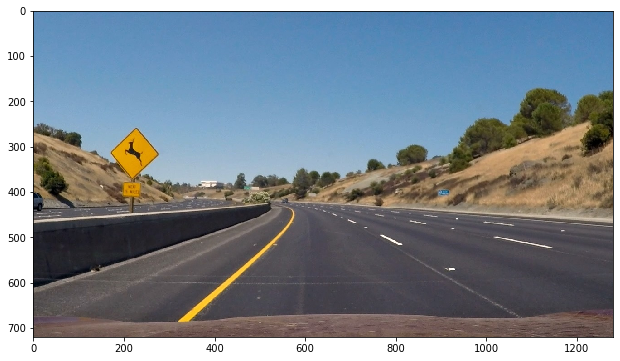

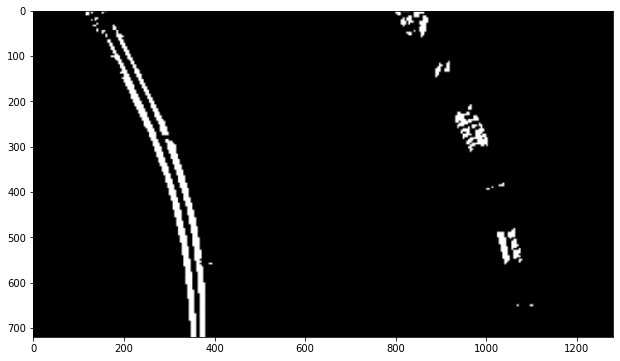

In [86]:
# Validate the HLS pipeline and plot pipeline frames
for test_img in test_images[6:7]:
    imgprinter.unblock()
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    bird_eye = bird.from_above(undistorter.undistort(img))
    contrast = adaptive_vertical_contrast(bird_eye)
    st_1 = contrast
    st_2 = normalize(amplify_vert_lane_pixels(st_1, angle_range=(-0.5, 0.5),
                                              magnitude_range=(20,255),
                                             sobel_kernel=3))
    plot_bgr(img)
    plot_gray(st_2)

In [87]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 27/720 # meters per pixel in y dimension for the regular video
xm_per_pix = 3.7/740 # meters per pixel in x dimension for the regular video

In [88]:
def evaluate_poly2(poly, y):
    ''' Evaluate a 2-grade polynomial '''
    return poly[0]*y*y + poly[1]*y + poly[2]

def get_lane_template_birdeye(shape, lane_width = 60):
    width = shape[1]
    left_line_desired_position = width * 1 // 4
    right_line_desired_position = width * 3 // 4
    salted = np.zeros(shape, dtype=np.uint8)
    salted[:, left_line_desired_position-lane_width:left_line_desired_position+lane_width] = 255
    salted[:, right_line_desired_position-lane_width:right_line_desired_position+lane_width] = 255
    return salted

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high, win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high, win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    imgprinter.write(out_img, "lane_pixel_finding")
    return leftx, lefty, rightx, righty

def take_lane_pixels(binary_warped, lcurve, rcurve, margin=50, downsample_rate=2):
    """
    Expects lcurve and rcurve as array of points.
    Vertical stride along the curve must be the same, and must be
    equal across both curves.
    These points are used as window origins: the point is a [bottom, h_center] of
    a window.
    Curves must be consistent with an image (e.g. of the same height and compatible width)
    Not all of the pixels might be taken into account if the downsample rate is > 1
    (this way further polynome fitting becomes faster)
    """
    assert(len(lcurve) > 2 and len(rcurve) > 2)
    l_v_stride = lcurve[1][1] - lcurve[0][1]
    r_v_stride = rcurve[1][1] - rcurve[0][1]
    assert(l_v_stride == r_v_stride)
    v_stride = l_v_stride
    leftx = []; lefty = []; rightx = []; righty = []
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    for point in lcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            leftx.append(w_x_indices + w_left-1)
            lefty.append(w_y_indices + w_top-1)
        # DEBUG!
        # binary_warped[y:y+v_stride:2, w_left:w_right:2] = 255
    for point in rcurve:
        x, y = point
        w_left = x - margin; w_right = x + margin
        w_top = y; w_bottom = y + v_stride
        window = binary_warped[w_top:w_bottom, w_left:w_right]
        w_y_indices, w_x_indices = window.nonzero()
        if len(w_x_indices > 0):
            rightx.append(w_x_indices + w_left-1)
            righty.append(w_y_indices + w_top-1)
        # DEBUG!
        # binary_warped[y:y+v_stride:2, w_left:w_right:2] = 255
    leftx = np.concatenate(leftx) if len(leftx) > 0 else np.uint16([])
    lefty = np.concatenate(lefty) if len(lefty) > 0 else np.uint16([])
    rightx = np.concatenate(rightx) if len(rightx) > 0 else np.uint16([])
    righty = np.concatenate(righty) if len(righty) > 0 else np.uint16([])
    return leftx, lefty, rightx, righty
    



In [89]:
'''
image_tricolor = cv2.imread("bird_eye.png")
test_takepixel_img = cv2.cvtColor(image_tricolor, cv2.COLOR_BGR2GRAY)
test_takepixel_img.shape

lx,ly,rx,ry = find_lane_pixels(test_takepixel_img)
lfit, rfit = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)

lx2,ly2,rx2,ry2 = take_lane_pixels(test_takepixel_img, lcurve, rcurve)

testplot = np.zeros_like(image_tricolor)
testplot[ly2, lx2, 0] = 255
testplot[:,:,1] = test_takepixel_img
testplot[ry2, rx2, 2] = 255


plot_bgr(test_takepixel_img)
plot_bgr(testplot)'''


'\nimage_tricolor = cv2.imread("bird_eye.png")\ntest_takepixel_img = cv2.cvtColor(image_tricolor, cv2.COLOR_BGR2GRAY)\ntest_takepixel_img.shape\n\nlx,ly,rx,ry = find_lane_pixels(test_takepixel_img)\nlfit, rfit = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)\nlcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)\n\nlx2,ly2,rx2,ry2 = take_lane_pixels(test_takepixel_img, lcurve, rcurve)\n\ntestplot = np.zeros_like(image_tricolor)\ntestplot[ly2, lx2, 0] = 255\ntestplot[:,:,1] = test_takepixel_img\ntestplot[ry2, rx2, 2] = 255\n\n\nplot_bgr(test_takepixel_img)\nplot_bgr(testplot)'

In [90]:
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, xm_per_pix, ym_per_pix):
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        salted = get_lane_template_birdeye(binary_warped.shape)
        leftx, lefty, rightx, righty = find_lane_pixels(salted)
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit

def get_plottable_curves(height, left_fit, right_fit, xm_per_pix, ym_per_pix, steps=20):
    ploty = np.linspace(0, height, steps)
    left_curve = np.int32(list(zip(
        evaluate_poly2(left_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    right_curve = np.int32(list(zip(
        evaluate_poly2(right_fit, ploty * ym_per_pix) / xm_per_pix, ploty)))
    return left_curve, right_curve
    
def plot_lane_curves(lane_img, left_curve, right_curve, thickness=6):
    out_img = cv2.polylines(lane_img, [left_curve], False, [0,255,255], thickness)
    out_img = cv2.polylines(out_img, [right_curve], False, [255,255,0], thickness)
    return out_img

def plot_lane_poly_on(lane_img, left_curve, right_curve, color=[100,200,100]):
    # Right curve's points must go in the opposite order to maintain a
    # polygon's points traversing order.
    points = np.append(left_curve, right_curve[::-1], axis=0)
    cv2.fillPoly(lane_img, [points], color)

In [91]:
from lane_line import LaneLine

In [92]:
def plot_circles(img, lcurv, rcurv):
    avg_curv = (lcurv + rcurv) / 2
    r_color = [0, 0, 255]
    l_color = [255, 0, 255]
    thickness = 15
    height, width = img.shape[:2]
    h_center = width // 2
    left_avg_center = (int(h_center - avg_curv), height)
    right_avg_center = (int(h_center + avg_curv), height)
    cv2.circle(img, left_avg_center, int(avg_curv), l_color, thickness)
    cv2.circle(img, right_avg_center, int(avg_curv), r_color, thickness)
    
def plot_curvatures_on(img, lcurvature, rcurvature, color=(255, 255, 255), fontScale = 1.2, thickness = 2):
    height, width = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    origin = (int(width * 0.05), int(height * 0.1)) 

    # Using cv2.putText() method 
    return cv2.putText(img, 
                        "Radius: left {:5.1f} m, right {:5.1f} m, avg lane {:5.1f} m"
                        .format(lcurvature, rcurvature, (lcurvature + rcurvature) / 2), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)

def plot_hcenter_offset_on(img, loffset, roffset, thickness = 1):
    offset = loffset + roffset
    height, width = img.shape[:2]
    green = (0, 100, 0)
    red = (100, 0, 0)
    origin = (int(width * 0.55), int(height * 0.9)) if (offset > 0) else (int(width * 0.35), int(height * 0.9)) 
    color = green if (offset > 0) else red
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1.2; thickness = 2
    return cv2.putText(img, 
                        "Offset {} mm" .format(int(offset)), 
                        origin, font,  
                       fontScale, color, thickness, cv2.LINE_AA)
    

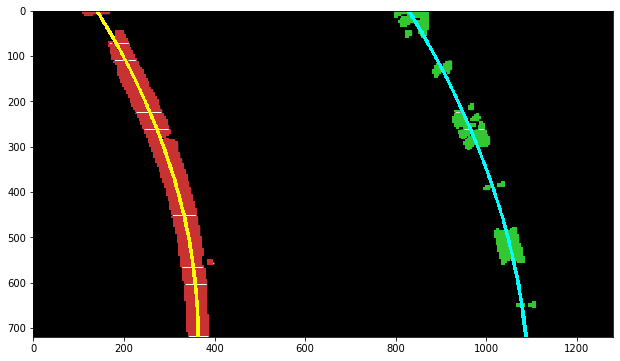

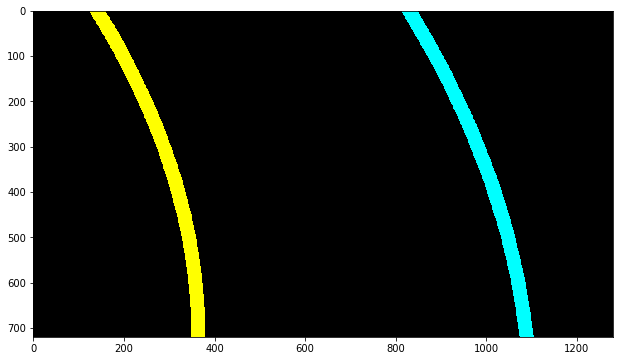

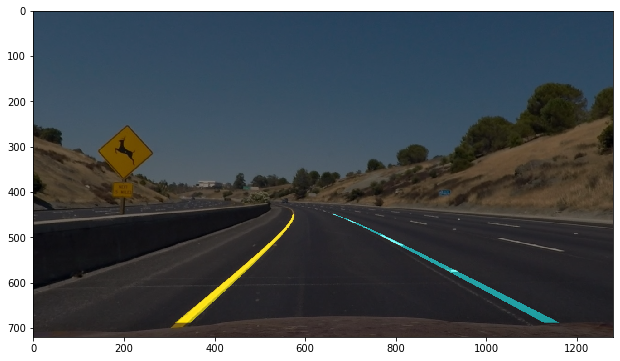

In [93]:
# Validate lane pixel finding via sliding window
for test_img in test_images[6:7]:
    imgprinter.block()
    img = cv2.resize(undistorter.undistort(cv2.imread(test_img)), (1280, 720))
    hls = adaptive_vertical_contrast(bird.from_above(img))
    highlight = amplify_vert_lane_pixels(hls)
    birds_eye = highlight
    lx, ly, rx, ry = find_lane_pixels(birds_eye)
    cv2.imwrite("bird_eye.png", birds_eye)
    lfit, rfit = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve, rcurve = get_plottable_curves(img.shape[0], lfit, rfit, xm_per_pix, ym_per_pix)
    lx, ly, rx, ry = take_lane_pixels(birds_eye, lcurve, rcurve)
    lfit2, rfit2 = fit_polynomial(birds_eye, lx, ly, rx, ry, xm_per_pix, ym_per_pix)
    lcurve2, rcurve2 = get_plottable_curves(img.shape[0], lfit2, rfit2, xm_per_pix, ym_per_pix)

    found = cv2.cvtColor(birds_eye, cv2.COLOR_GRAY2BGR)
    found[ly, lx] = [50, 50 ,200]
    found[ry, rx] = [50, 200,50]
    found = plot_lane_curves(found, lcurve, rcurve)
    found = plot_lane_curves(found, lcurve2, rcurve2)

    lcurv = LaneLine.curvature(lfit, 720 * ym_per_pix)
    rcurv = LaneLine.curvature(rfit, 720 * ym_per_pix)
      
    imgprinter.unblock()
    plot_bgr(found)
    imgprinter.write(found, "detected_lane_pixels")
    
    lane_curves_from_above = plot_lane_curves(np.zeros_like(found), lcurve, rcurve, thickness=30)
    plot_bgr(lane_curves_from_above)
    
    lane_curves_on_road = bird.to_road(lane_curves_from_above)
    demo = np.uint8((img.astype(np.uint16) + lane_curves_on_road)//2)
    plot_bgr(demo)
    imgprinter.write(demo, "demo_lanes_detected")

In [106]:
# Note: an Undistorter instance is necessary
# with avg 10 lanes work. L8 + Buf32(_20) is ok too.
# Avg6 + Buf32(_20) works too.
# Avg4 + Buf8(_40) for regular video is ok
# Avg8 + Buf8(_20) for challenge is ok too.
rlane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Right")
llane = LaneLine(xm_per_pix, ym_per_pix, avg_depth=8, max_valid_diff=0.75, max_broken_frames=12, name="Left")

buffer_frame = None
buf_avg = 12

def process_frame(frame, plot_everything=True):
    imgprinter.block()
    global buffer_frame, buf_avg
    global rlane, llane
    
    is_all_ok = (llane.is_valid() and rlane.is_valid())
    downsample_rate = 2
    
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    birds_eye = bird.from_above(undistorter.undistort(frame))
    stage_0_sample = adaptive_vertical_contrast(birds_eye, downsample_rate=downsample_rate)
    stage_1_sample = amplify_vert_lane_pixels(stage_0_sample, downsample_rate=downsample_rate)
    stage_2_sample = normalize(stage_1_sample)
    
    if buffer_frame is None:
        buffer_frame = np.uint32(stage_2_sample)
    else:
        buffer_frame = (buffer_frame * (buf_avg - 1) + stage_2_sample) / buf_avg

    filtered_stage2 = np.zeros_like(stage_2_sample)
    filtered_stage2[buffer_frame > 20] = 1
    filtered_stage2 = cv2.morphologyEx(filtered_stage2, cv2.MORPH_OPEN, np.ones((5,5)))

    if is_all_ok:
        # Faster
        downsample_rate = 10
        lx, ly, rx, ry = take_lane_pixels(filtered_stage2,
                                          llane.get_curve(),
                                          rlane.get_curve(),
                                          margin=80)
    else:
        # More robust
        downsample_rate = 2
        lx, ly, rx, ry = find_lane_pixels(filtered_stage2)
    
    # To fit a polynome curve, we need as few points as possible, as it 
    # speeds up computations; but not too few to keep the accuracy.
    fit_downsample = 1 + max(len(lx), len(ly)) // 1000
    lfit, rfit = fit_polynomial(filtered_stage2,
                                lx[::fit_downsample],
                                ly[::fit_downsample],
                                rx[::fit_downsample],
                                ry[::fit_downsample],
                                xm_per_pix, ym_per_pix)
    llane.update(lfit); 
    rlane.update(rfit);
    
    lcurve, rcurve = get_plottable_curves(height, llane.get_fit(), rlane.get_fit()
                                          , xm_per_pix, ym_per_pix, steps=15)
    llane.set_curve(lcurve)
    rlane.set_curve(rcurve)
    
    
    stage_3_sample = plot_lane_curves(cv2.cvtColor(normalize(filtered_stage2),
                                                   cv2.COLOR_GRAY2BGR)
                                      , lcurve, rcurve)
    
    road_poly_from_above = np.zeros_like(frame)
    poly_color = [100,200,100] if is_all_ok else [255,0,0]
    plot_lane_poly_on(road_poly_from_above, lcurve, rcurve, color=poly_color)
    lane_poly = bird.to_road(road_poly_from_above)
    detection_result = np.maximum(frame, lane_poly)
    plot_curvatures_on(detection_result, llane.get_radius(), rlane.get_radius())
    plot_hcenter_offset_on(detection_result, llane.get_horizontal_offset(), rlane.get_horizontal_offset())

    if not plot_everything:
        return detection_result
            
    tile_00 = cv2.resize(detection_result, (width//2, height//2))
    tile_01 = cv2.cvtColor(cv2.resize(stage_0_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_10 = cv2.cvtColor(cv2.resize(stage_1_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(stage_3_sample, (width//2, height//2))

    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    imgprinter.block()
    return output

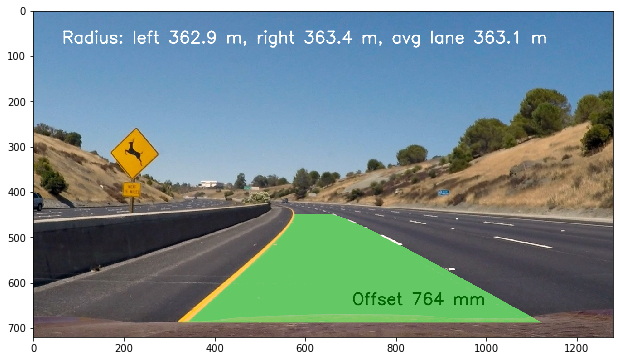

In [95]:
# Validate lane pixel finding via sliding window
for test_img in test_images[6:7]:
    for i in range(0, 10): # processing the same frame several times to trigger averaging
        img = cv2.resize(cv2.imread(test_img), (1280, 720))
        process_frame(img)
    result = process_frame(img)
    plot_bgr(result)
    buffer_frame = None
    llane.reset()
    rlane.reset()
    imgprinter.write(result, "pipeline_result")


In [107]:
#input_video = 'harder_challenge_video.mp4'; test_video_output = 'test_video_output/harder_challenge_test_video.mp4'
input_video = 'challenge_video.mp4'; test_video_output = 'test_video_output/challenge_test_video.mp4'
#input_video = 'project_video.mp4'; test_video_output = 'test_video_output/test_video.mp4'
imgprinter.block()
# 37-43 subclip of the main one is the worst, challenge problem on 3..6
clip1 = VideoFileClip(input_video).subclip(2,7)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)
imgprinter.unblock()

t:   2%|▏         | 3/150 [00:00<00:07, 19.08it/s, now=None]

Moviepy - Building video test_video_output/challenge_test_video.mp4.
Moviepy - Writing video test_video_output/challenge_test_video.mp4



t:  19%|█▉        | 29/150 [00:02<00:09, 13.26it/s, now=None]

ALARM! LANE Left BROKEN!
ALARM! LANE Left BROKEN!
ALARM! LANE Left BROKEN!


t:  21%|██        | 31/150 [00:02<00:09, 13.04it/s, now=None]

ALARM! LANE Left BROKEN!
ALARM! LANE Left BROKEN!
ALARM! LANE Left BROKEN!


t:  23%|██▎       | 35/150 [00:02<00:09, 12.76it/s, now=None]

ALARM! LANE Left BROKEN!


Moviepy - Done !
Moviepy - video ready test_video_output/challenge_test_video.mp4
CPU times: user 32.8 s, sys: 194 ms, total: 33 s
Wall time: 13.1 s
